<a href="https://colab.research.google.com/github/maramatef111/Elevvo-Internship-Tasks/blob/main/Walmart_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing necessary libraries**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


#**Data Loading and Inspection**

In [38]:
train_df = pd.read_csv("/content/train.csv")
stores_df = pd.read_csv("/content/stores.csv")
features_df = pd.read_csv("/content/features.csv")

##**Merge data**

In [39]:
merged_df = pd.merge(train_df, stores_df, on='Store', how='left')
merged_df = pd.merge(merged_df, features_df, on=['Store', 'Date'], how='left')
display(merged_df.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [40]:
merged_df.to_csv("merged_data1.csv", index=False)

In [41]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [42]:
(merged_df['IsHoliday_x'] == merged_df['IsHoliday_y']).all()

np.True_

In [63]:
merged_df['IsHoliday'] = merged_df['IsHoliday_x']   # or 'IsHoliday_y'
merged_df.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)

In [64]:
merged_df['IsHoliday'] = merged_df['IsHoliday'].astype(int)

In [44]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [45]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     150681 non-null  float64
 9   MarkDown2     111248 non-null  float64
 10  MarkDown3     137091 non-null  float64
 11  MarkDown4     134967 non-null  float64
 12  MarkDown5     151432 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [46]:
merged_df.describe(include='number')

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [47]:
merged_df.describe(include='bool')

,IsHoliday
count,421570
unique,2
top,False
freq,391909


#**Data Cleaning**

##**Check Duplication**

In [48]:
merged_df.duplicated().sum()

np.int64(0)

##**Data Format or rename columns**

In [49]:
merged_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday'],
      dtype='object')

In [50]:
num_cols = merged_df.select_dtypes('number').columns
cat_cols = merged_df.select_dtypes('object').columns

print('Numerical Columns: ', num_cols)
print('Categorical Columns: ', cat_cols)

Numerical Columns:  Index(['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment'],
      dtype='object')
Categorical Columns:  Index(['Date', 'Type'], dtype='object')


In [51]:
merged_df.dtypes

,0
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
Type,object
Size,int64
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64


In [62]:
merged_df['Date']=pd.to_datetime(merged_df['Date'])

In [52]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [53]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     150681 non-null  float64
 9   MarkDown2     111248 non-null  float64
 10  MarkDown3     137091 non-null  float64
 11  MarkDown4     134967 non-null  float64
 12  MarkDown5     151432 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


#**Missing Data Analysis**

In [54]:
merged_df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
Type,0
Size,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322


In [55]:
def check_missing(df):
    missing = df.isna().sum()
    missing = missing[missing>0].sort_values()
    missing_df = pd.DataFrame(missing, columns=['Missing#'])
    missing_df['Missing%'] = missing_df['Missing#']/len(df)
    missing_df = missing_df.reset_index(names='Feature')

    return missing_df

In [56]:
# Check for missing values
check_missing(merged_df)

,Feature,Missing#,Missing%
0,MarkDown5,270138,0.640790
1,MarkDown1,270889,0.642572
2,MarkDown3,284479,0.674808
3,MarkDown4,286603,0.679847
4,MarkDown2,310322,0.736110


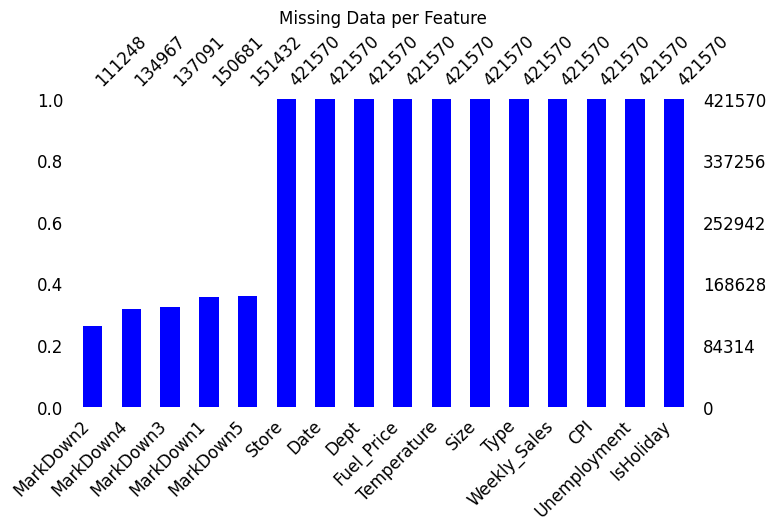

In [57]:
# Bar chart showing total missing values per feature
msno.bar(merged_df, color='blue', fontsize=12, figsize=(8, 4), sort='ascending')
plt.title("Missing Data per Feature")
plt.show()

#**Handle Missing Values**

handle missing values in the MarkDown columns by filling them with 0, as markdown values typically represent discounts and missing values likely indicate no discount was applied. For 'CPI' and 'Unemployment', forward fill the missing values as these are time-series data and the previous values are likely the most relevant.

In [58]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
merged_df[markdown_cols] = merged_df[markdown_cols].fillna(0)
display(merged_df.info())
display(merged_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


None

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
Type,0
Size,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0


#**Create time-based features**

Extract time-based features (month, year, week, day of week) from the 'Date' column, sort the DataFrame, and create a lag feature for 'Weekly_Sales'. Then, display the first few rows to show the new features.


In [59]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek
merged_df['Weekly_Sales_Lag_1'] = merged_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
display(merged_df.head())

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,DayOfWeek,Weekly_Sales_Lag_1
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2010,2,4,NaN
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True,2010,2,4,24924.50
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,2010,2,4,46039.49
3,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False,2010,2,4,41595.55
4,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False,2010,3,4,19403.54


In [60]:
merged_df['Weekly_Sales_Lag_1'] = merged_df['Weekly_Sales_Lag_1'].fillna(0)

In [61]:
merged_df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
Type,0
Size,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0


In [65]:
merged_df = pd.get_dummies(merged_df, columns=['Type'], drop_first=True)

In [66]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,DayOfWeek,Weekly_Sales_Lag_1,Type_B,Type_C
0,1,1,2010-02-05,24924.50,151315,42.31,2.572,0.0,0.0,0.0,...,0.0,211.096358,8.106,0,2010,2,4,0.00,False,False
1,1,1,2010-02-12,46039.49,151315,38.51,2.548,0.0,0.0,0.0,...,0.0,211.242170,8.106,1,2010,2,4,24924.50,False,False
2,1,1,2010-02-19,41595.55,151315,39.93,2.514,0.0,0.0,0.0,...,0.0,211.289143,8.106,0,2010,2,4,46039.49,False,False
3,1,1,2010-02-26,19403.54,151315,46.63,2.561,0.0,0.0,0.0,...,0.0,211.319643,8.106,0,2010,2,4,41595.55,False,False
4,1,1,2010-03-05,21827.90,151315,46.50,2.625,0.0,0.0,0.0,...,0.0,211.350143,8.106,0,2010,3,4,19403.54,False,False


#**Exploratory Data Analysis (EDA)**

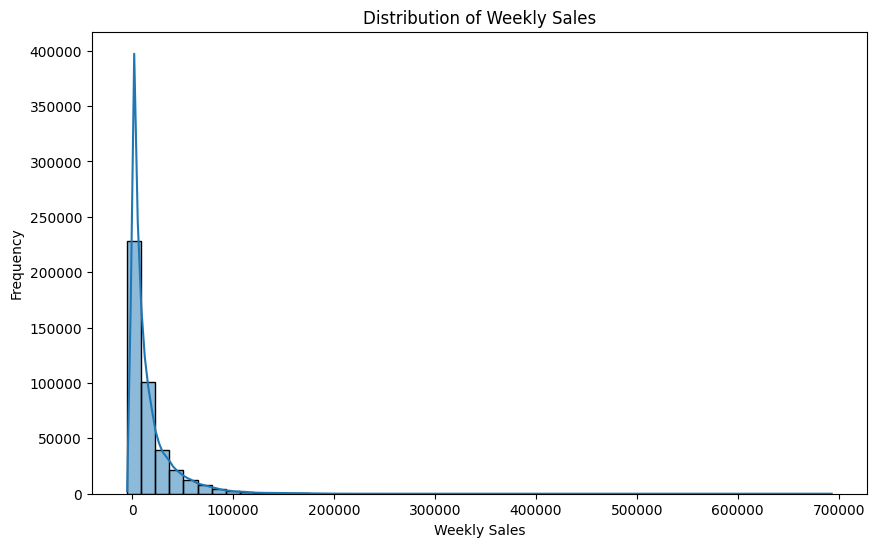

In [67]:
# Distribution of Weekly Sales
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

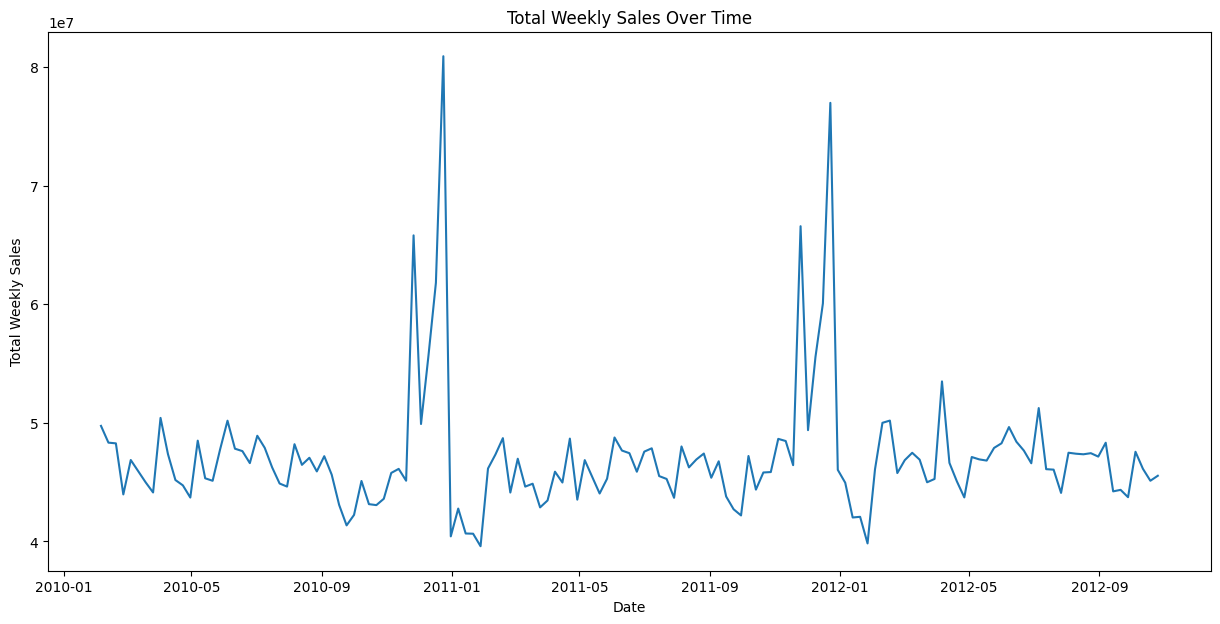

In [68]:
# Total Weekly Sales Over Time
weekly_sales_over_time = merged_df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(15, 7))
plt.plot(weekly_sales_over_time['Date'], weekly_sales_over_time['Weekly_Sales'])
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()


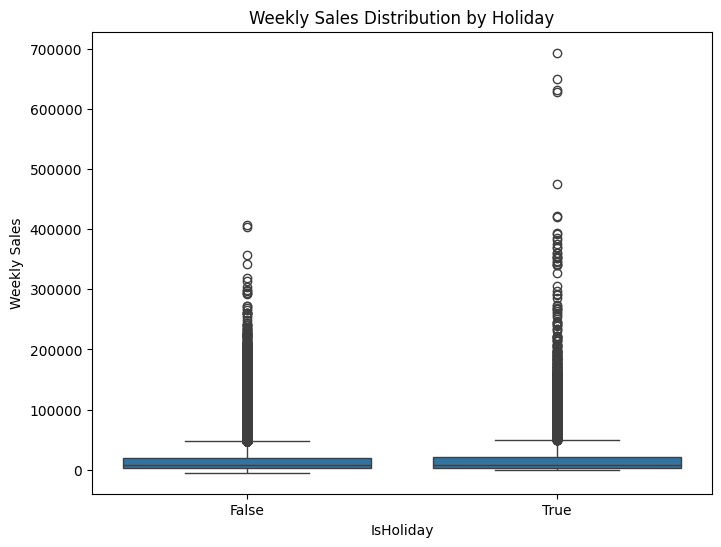

In [69]:

# Impact of Holidays on Weekly Sales
plt.figure(figsize=(8, 6))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=merged_df)
plt.title('Weekly Sales Distribution by Holiday')
plt.xlabel('IsHoliday')
plt.ylabel('Weekly Sales')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

#**Model Selection**

Subtask:
Choose appropriate regression models for time series forecasting (e.g., Linear Regression, XGBoost, LightGBM).

##**Model Training**

In [71]:
X = merged_df.drop(['Weekly_Sales', 'Date', 'IsHoliday_x', 'IsHoliday_y', 'Type'], axis=1, errors='ignore')
y = merged_df['Weekly_Sales']

split_date = pd.to_datetime('2012-01-01')
X_train = X[merged_df['Date'] < split_date]
X_test = X[merged_df['Date'] >= split_date]
y_train = y[merged_df['Date'] < split_date]
y_test = y[merged_df['Date'] >= split_date]

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgb_model.fit(X_train, y_train)

print("Models trained successfully.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 294132, number of used features: 18
[LightGBM] [Info] Start training from score 16105.306894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

##**Prediction**

In [72]:
linear_predictions = linear_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)

print("Predictions made successfully.")

Predictions made successfully.


##**Evaluation**

Evaluate the model performance using appropriate metrics (e.g., Mean Absolute Error, Root Mean Squared Error).

In [74]:
mae_linear = mean_absolute_error(y_test, linear_predictions)
rmse_linear = np.sqrt(mean_squared_error(y_test, linear_predictions))

mae_xgb = mean_absolute_error(y_test, xgb_predictions)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_predictions))

mae_lgb = mean_absolute_error(y_test, lgb_predictions)
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_predictions))

print(f"Linear Regression - MAE: {mae_linear:.2f}, RMSE: {rmse_linear:.2f}")
print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
print(f"LightGBM - MAE: {mae_lgb:.2f}, RMSE: {rmse_lgb:.2f}")

Linear Regression - MAE: 2484.09, RMSE: 4406.50
XGBoost - MAE: 1811.48, RMSE: 3990.33
LightGBM - MAE: 1805.68, RMSE: 3979.01


##**Plotting**

Plot actual vs. predicted sales values over time to visualize the model's performance.

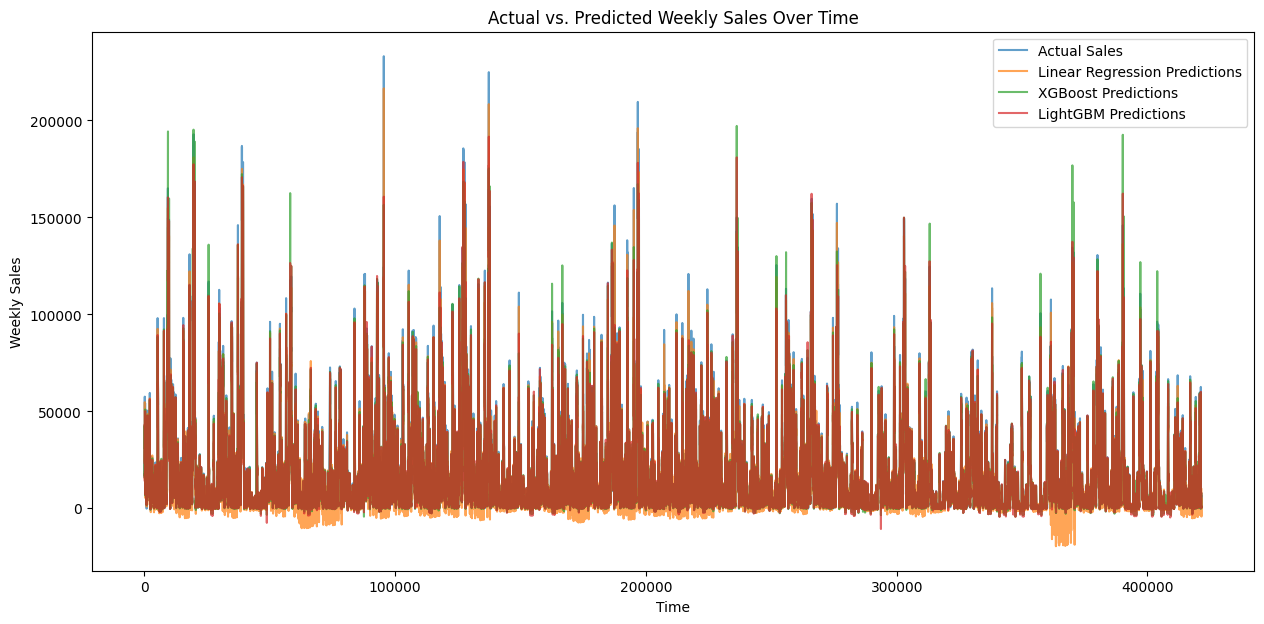

In [75]:
results_df = y_test.to_frame(name='Actual_Sales')
results_df['linear_predictions'] = linear_predictions
results_df['xgb_predictions'] = xgb_predictions
results_df['lgb_predictions'] = lgb_predictions

results_df = results_df.sort_index()

plt.figure(figsize=(15, 7))
plt.plot(results_df.index, results_df['Actual_Sales'], label='Actual Sales', alpha=0.7)
plt.plot(results_df.index, results_df['linear_predictions'], label='Linear Regression Predictions', alpha=0.7)
plt.plot(results_df.index, results_df['xgb_predictions'], label='XGBoost Predictions', alpha=0.7)
plt.plot(results_df.index, results_df['lgb_predictions'], label='LightGBM Predictions', alpha=0.7)

plt.title('Actual vs. Predicted Weekly Sales Over Time')
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

#**Bonus features**

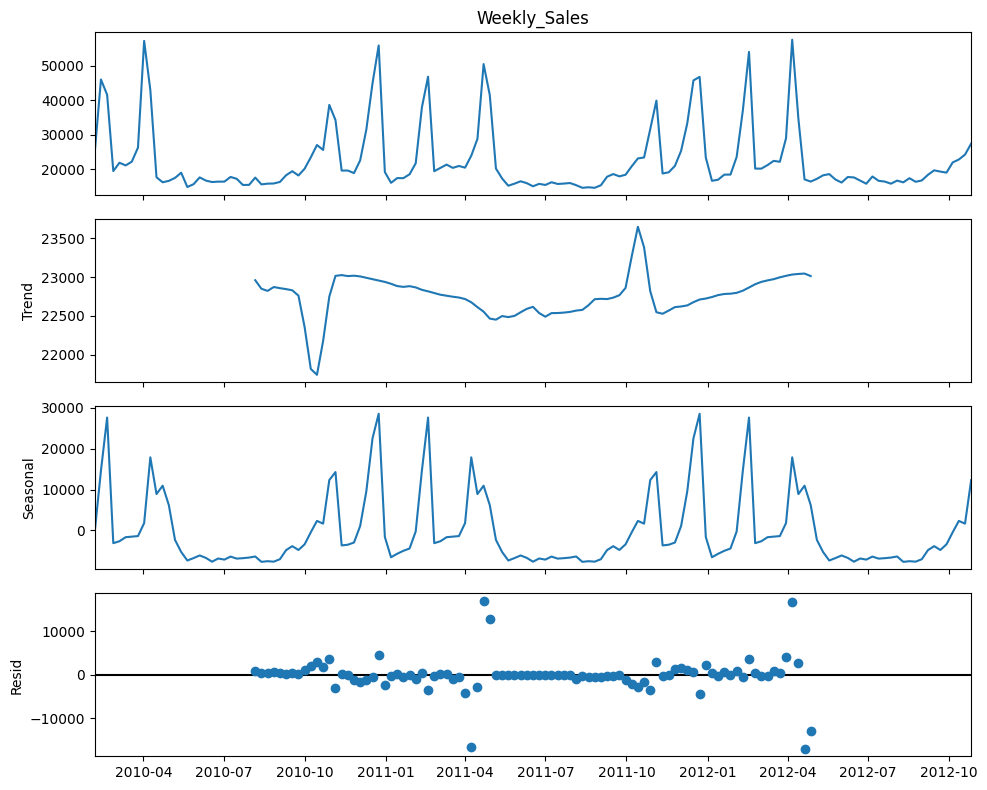

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,IsHoliday,Year,Month,DayOfWeek,Weekly_Sales_Lag_1,Type_B,Type_C,Weekly_Sales_Rolling_Mean_4,Weekly_Sales_Rolling_Mean_12
0,1,1,2010-02-05,24924.50,151315,42.31,2.572,0.0,0.0,0.0,...,8.106,0,2010,2,4,0.00,False,False,NaN,NaN
1,1,1,2010-02-12,46039.49,151315,38.51,2.548,0.0,0.0,0.0,...,8.106,1,2010,2,4,24924.50,False,False,NaN,NaN
2,1,1,2010-02-19,41595.55,151315,39.93,2.514,0.0,0.0,0.0,...,8.106,0,2010,2,4,46039.49,False,False,NaN,NaN
3,1,1,2010-02-26,19403.54,151315,46.63,2.561,0.0,0.0,0.0,...,8.106,0,2010,2,4,41595.55,False,False,32990.77,NaN
4,1,1,2010-03-05,21827.90,151315,46.50,2.625,0.0,0.0,0.0,...,8.106,0,2010,3,4,19403.54,False,False,32216.62,NaN


In [77]:
merged_df['Weekly_Sales_Rolling_Mean_4'] = merged_df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())
merged_df['Weekly_Sales_Rolling_Mean_12'] = merged_df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=12).mean())

# Choose a store and department with sufficient data
store_id = 1
dept_id = 1
store_dept_data = merged_df[(merged_df['Store'] == store_id) & (merged_df['Dept'] == dept_id)].set_index('Date').sort_index()

# Perform seasonal decomposition if enough data points exist
if len(store_dept_data) >= 24: # Typically need at least two periods for decomposition
    decomposition = seasonal_decompose(store_dept_data['Weekly_Sales'], model='additive', period=52) # Assuming weekly data and yearly seasonality (52 weeks)

    # Plot the decomposition
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough data for Store {store_id}, Dept {dept_id} to perform seasonal decomposition.")

display(merged_df.head())

## Summary:

### Data Analysis Key Findings

*   The analysis successfully merged sales, store, and features data into a single DataFrame, identifying initial missing values in 'MarkDown' columns and potential redundancy in 'IsHoliday' columns.
*   Time-based features (Year, Month, DayOfWeek) and a 1-week sales lag ('Weekly\_Sales\_Lag\_1') were successfully engineered.
*   Missing values in 'MarkDown' columns and 'Weekly\_Sales\_Lag\_1' were imputed with 0. The two 'IsHoliday' columns were consolidated into a single integer 'IsHoliday' column, and the categorical 'Type' column was one-hot encoded.
*   Three regression models (Linear Regression, XGBoost, and LightGBM) were selected and trained on a time-based split of the data (pre-2012 for training, post-2012 for testing).
*   Model evaluation using MAE and RMSE showed that both XGBoost (MAE: 1811.48, RMSE: 3990.33) and LightGBM (MAE: 1805.68, RMSE: 3979.01) significantly outperformed Linear Regression (MAE: 2484.09, RMSE: 4406.50) in predicting weekly sales. LightGBM had a marginal edge over XGBoost.
*   Rolling averages for 4 and 12 weeks were calculated and added as features. Seasonal decomposition was successfully performed and visualized for a specific store and department, showing clear trend, seasonal, and residual components.

### Insights or Next Steps

*   Focus on optimizing the parameters of XGBoost and LightGBM models, as they demonstrated superior performance compared to Linear Regression.
*   Explore the insights from the seasonal decomposition plots for different stores and departments to understand varying seasonal patterns and potentially incorporate more granular seasonal features into the models.